In [1]:
!pip install transformers==4.17.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 KB 60.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 98.6 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
import os
from timeit import default_timer
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, TFBertForSequenceClassification, BertConfig

In [4]:
df = pd.read_csv('train.csv', index_col=0)

In [5]:
df_test = pd.read_csv('test.csv', index_col=0)

In [6]:
# train dataset
df.head()

,Text,Sentiment
Id,,
0,American movies about war and Nazis simply can...,0
1,Who would have thought that a movie about a ma...,1
2,"Well, as Goethe once said, there really isn't ...",0
3,"Ever since I remember, I have loved airplanes ...",1
4,There are often badly-matched couples (in the ...,0


In [7]:
# test dataset
df_test.head()

,Text
Id,
0,This is probably the best movie from director ...
1,It's particularly hard for a director to captu...
2,A very good movie about anti-semitism near the...
3,Interesting story and sympathetic treatment of...
4,There are films that are not released in theat...


<Axes: >

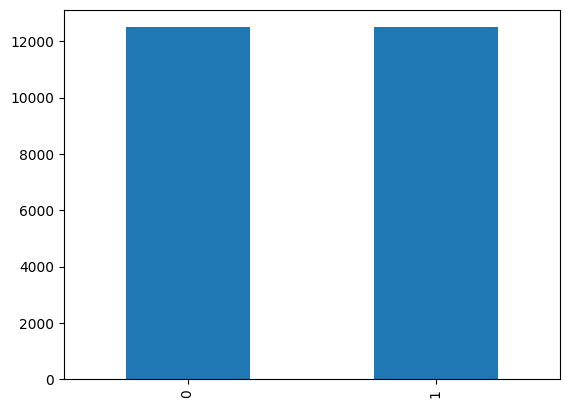

In [8]:
#Check the split of the sentiments

df["Sentiment"].value_counts().plot(kind="bar")

In [9]:
# train dataset no of rows
seqlen = df["Text"].apply(lambda x: len(x.split()))
print(seqlen.shape)

(24995,)


In [10]:
#test dataset no of rows
seqlen_test = df_test["Text"].apply(lambda x: len(x.split()))
print(seqlen_test.shape)

(25865,)


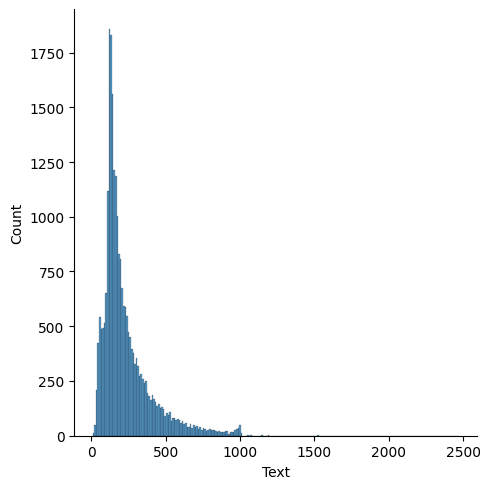

<Figure size 3000x1500 with 0 Axes>

In [11]:
#Distribution of length for the reviews in train dataset
sns.displot(seqlen)

sns.set_style("darkgrid")
plt.figure(figsize=(30, 15))
plt.show()

In [12]:
seq_len = 512
num_samples = len(df)
num_samples

24995

In [13]:
# The final best model did not use any preprocessing of the reviews text
# raw text of the reviews were tokenized

# split into features and labels
texts = df['Text'].tolist()
labels = df["Sentiment"].tolist()

# Split the train data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)


In [14]:
#tokenize the texts in train dataset
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_data(texts, labels):
    encodings = tokenizer(texts, truncation=True, padding=True, return_tensors="tf")
    return {"input_ids": encodings["input_ids"], "attention_mask": encodings["attention_mask"], "labels": labels}

train_encodings = tokenize_data(train_texts, train_labels)
val_encodings = tokenize_data(val_texts, val_labels)

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [15]:
#Compile Bert model for fine-tuning and train with the training data

def create_tf_dataset(encodings):
    return tf.data.Dataset.from_tensor_slices(({"input_ids": encodings["input_ids"], "attention_mask": encodings["attention_mask"]}, encodings["labels"])).batch(8)


train_dataset = create_tf_dataset(train_encodings)
val_dataset = create_tf_dataset(val_encodings)

config = BertConfig.from_pretrained("bert-base-uncased", num_labels=2)
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
history = model.fit(train_dataset, epochs=2, validation_data=val_dataset)

Epoch 1/2
2500/2500 [==============================] - 481s 173ms/step - loss: 0.2444 - accuracy: 0.8999 - val_loss: 0.1834 - val_accuracy: 0.9298
Epoch 2/2
2500/2500 [==============================] - 335s 134ms/step - loss: 0.1148 - accuracy: 0.9588 - val_loss: 0.2059 - val_accuracy: 0.9268


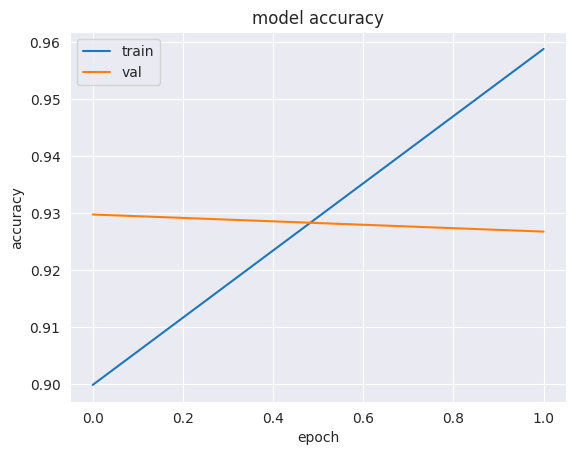

In [17]:
# Plot validation vs train accuracy over epochs for model training
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
#Tokenize whole dataset
encodings = tokenize_data(texts, labels)

In [19]:
# Compile and train model with whole train dataset
final_dataset = create_tf_dataset(encodings)

config = BertConfig.from_pretrained("bert-base-uncased", num_labels=2)
model = TFBertForSequenceClassification.from_pretrained("bert-base-uncased", config=config)

optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy("accuracy")

model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

history = model.fit(final_dataset, epochs=2)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/2
3125/3125 [==============================] - 497s 145ms/step - loss: 0.2345 - accuracy: 0.9039
Epoch 2/2
3125/3125 [==============================] - 381s 122ms/step - loss: 0.1139 - accuracy: 0.9602


In [20]:
#Tokenize the test dataset and use the trained model to predict the output
# Save the output prediction of test dataset to be submitted in Kaggle

text_test = df_test['Text'].tolist()

encodings_test_temp = tokenizer(text_test, truncation=True, padding=True, return_tensors="tf")
encodings_test = {"input_ids": encodings_test_temp["input_ids"], "attention_mask": encodings_test_temp["attention_mask"]}

test_dataset = tf.data.Dataset.from_tensor_slices(({"input_ids": encodings_test["input_ids"], "attention_mask": encodings_test["attention_mask"]})).batch(8)

ensemble_preds_test = model.predict(test_dataset)

output = ensemble_preds_test 
logits = output.logits
predicted_labels = np.argmax(logits, axis=1)

print(predicted_labels)

id = np.arange(0,seqlen_test.shape[0])
submission_df = pd.DataFrame(data=[id, predicted_labels]).T
submission_df.columns = ['Id', 'Sentiment']
submission_df.to_csv('submission.csv', index=False)

3234/3234 [==============================] - 156s 47ms/step
[1 1 1 ... 1 0 0]
